In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix


### Import cleaned dataset to be used for building ML Models to predict Scantool success.

In [2]:
diag_usage_df = pd.read_excel('../Data/Diag_Usage_Full.xlsx', sheet_name='connect_system')

In [3]:
diag_usage_df.sample(5)

,timestamp,siteId,OsName,client_OS,vin,year,make,model,system,veh_desc,...,scan_method,batt_voltage,result_string,result,state,city,product_type,postal_code,system_category,make_category
68480,2024-10-10 12:32:23.785,499807,iOS,iOS 17.6.1,19XFL1H76NE,2022,Honda,Civic,Enhanced Powertrain,2022 Honda Civic,...,quick_scan,0.00,Successfully connected,1,SC,GREENVILLE,COLLISION,29607-2642,Enhanced Powertrain,asian_makes
152746,2025-01-11 01:04:02.221,537799,Android,Android 14,1HGCM56815A,2005,Honda,Accord,Enhanced Powertrain,2005 Honda Accord,...,quick_scan,13.39,Failed to connect to system,0,CA,Upland,COLLISION,91786-8438,Enhanced Powertrain,asian_makes
153296,2025-01-07 17:57:36.409,808039,Android,Android 8.1.0,5TDYSKFC6RS,2024,Toyota,Sienna,Enhanced Powertrain CAN,2024 Toyota Sienna,...,quick_scan,11.14,Successfully connected,1,DE,NEW CASTLE,COLLISION,19720,Enhanced Powertrain,asian_makes
64372,2024-11-01 15:45:54.575,429517,iOS,iOS 18.0.1,4T1BF3EK8BU,2011,Toyota,Camry,Enhanced Powertrain CAN,2011 Toyota Camry,...,quick_scan,12.22,Successfully connected,1,WA,Battle Ground,COLLISION,98604-8488,Enhanced Powertrain,asian_makes
147459,2025-01-14 18:10:55.274,72344,iPadOS,iPadOS 17.7.1,4S4BSAFC7J3,2018,Subaru,Outback,Enhanced Powertrain CAN,2018 Subaru Outback,...,quick_scan,14.22,Successfully connected,1,OR,Springfield,COLLISION,97477-5157,Enhanced Powertrain,asian_makes


In [4]:
diag_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165218 entries, 0 to 165217
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        165218 non-null  datetime64[ns]
 1   siteId           165218 non-null  int64         
 2   OsName           165218 non-null  object        
 3   client_OS        165218 non-null  object        
 4   vin              165218 non-null  object        
 5   year             165218 non-null  int64         
 6   make             165218 non-null  object        
 7   model            165218 non-null  object        
 8   system           165218 non-null  object        
 9   veh_desc         165218 non-null  object        
 10  vci_version      165218 non-null  object        
 11  scan_method      165218 non-null  object        
 12  batt_voltage     165218 non-null  float64       
 13  result_string    165218 non-null  object        
 14  result           165

### Two logistic regression models will be created - One with batt_voltage and one with it removed
For the model that uses batt_voltage, invalid samples will be removed. This will result in approximately 25% less samples but will allow us to determine if batt_voltage of the vehicle is valuable in predicting the ability to communicate with a vehicle. 

In [5]:
#remove features that are not useful
features_to_remove = ['siteId', 'timestamp', 'OsName', 'client_OS', 'vin', 'veh_desc', 'vci_version', 'system', 'result_string', 'state', 'city', 'postal_code', 'product_type', 'make_category']
lgr_model_df = diag_usage_df.drop(features_to_remove, axis = 1)

lgr_model_df.rename(columns = {'system_category':'system'}, inplace = True)

#convert year datatype to string. the age of the vehicle does not affect scanning success. the year is usfull for grouping into vehicle network architectures
#lgr_model_df['year'] = lgr_model_df['year'].astype(str)

#remove rows where battery voltage is 0 or less
lgr_model_df_batt = lgr_model_df[lgr_model_df['batt_voltage'] > 0]

#remove batt_voltage from lgr_model_df
lgr_model_df = lgr_model_df.drop('batt_voltage', axis = 1)

### Create train/test split
Features that are not believed to contribute to predicting success communicating with the vehicle will be removed. Also, features shown not to contribute to the scanning success during EDA will also be removed.<br/>
Note: While vin and veh_desc were important features during EDA, they will (at least initially be removed). The individual component features of the veh_desc will be used instead (make, model, year). The vin has too much information encoded in it and would cause overfitting. In the future, it may be possible to extract vehicle features from the vin that could be used for detailed models. 

In [6]:
#create train test split with even result ratio
X_train, X_test, y_train, y_test = train_test_split(lgr_model_df.drop(['result'], axis = 1), lgr_model_df['result'], random_state = 42,
                                                   stratify = lgr_model_df['result'])




In [7]:
X_train.head()

,year,make,model,scan_method,system
51630,2014,Toyota,Sienna,quick_scan,Enhanced Powertrain
60881,2020,Hyundai,Accent,manual scan,Enhanced Powertrain
36854,2019,Subaru,Forester,manual scan,Enhanced Powertrain
67483,2023,Jeep,Grand,manual scan,Braking System
58145,2004,Nissan,Maxima,quick_scan,Enhanced Powertrain


### Examine system feature distribution
As addressed during EDA, the system feature is imbalanced with 95% of samples having the Enhanced Powertrain value. The next two highest systems are Braking System with 1.38% and Airbag Control System with 1.04%. These three will be kept and the remaining system values will be added to the 'other' category. 

In [8]:
#keep the top 3 systems and set the rest to 'other'
#freq = lgr_model_df['system'].value_counts(normalize=True)

# Determine which systems occur in at least 1% of the samples
#valid_systems = freq[freq >= 0.01].index.tolist()

# Apply the mapping to the training set: if a system is not in valid_systems, set it to 'other'
#X_train['system'] = X_train['system'].apply(
#    lambda x: x if x in valid_systems else 'other'
#)

# Apply the same mapping to the test set
#X_test['system'] = X_test['system'].apply(
#    lambda x: x if x in valid_systems else 'other'
#)

In [9]:
X_test['system'].value_counts(normalize=True)

system
Enhanced Powertrain            0.955356
Braking System                 0.013776
Airbag Control System          0.010652
Transmission Control System    0.004140
Body Control System            0.002445
Occupant Sensing System        0.002276
Crash Safety System            0.002130
TPMS                           0.001646
ADAS                           0.001404
other                          0.001211
Power Steering System          0.000799
HVAC Control System            0.000629
Drive Motor Control System     0.000484
Radio Control System           0.000412
Fuel Pump                      0.000387
Chassis Control System         0.000363
Infotainment System            0.000339
General Electronics System     0.000315
Park Assist                    0.000291
Battery Management System      0.000266
Gateway                        0.000242
Theft Deterrent                0.000194
Head Lamp Control System       0.000097
Telematics                     0.000097
Accessory Power System         0.

### Determine which models to keep
During EDA, it was discovered that while the dataset contained 594 unique models. 95 models made up 80 percent of the sample data. These will be kept and remaining models will be added to the other category. 

In [10]:
#return list that contains the passed in percentage of the data for the passed in attribute and dataframe
def get_percentage_of_data(attribute, percentage, df):
    num_attributes = df[attribute].nunique()
    #print(f'Number of unique {attribute}s: {num_attributes}')
    counts = df[attribute].value_counts(normalize=True)
    cumulative_counts = counts.cumsum()
    cumulative_counts
    # Get the samples that make up percentage of the dataset
    samples_percentage = cumulative_counts[cumulative_counts <= percentage].index.tolist()
    return samples_percentage

### Create the logistic regression model

In [11]:
def Create_and_fit_lgr_model(X_train, y_train):
    # Define the column transformer
    selector = make_column_selector(dtype_include='object')
    transformer = make_column_transformer((OneHotEncoder(drop='first', handle_unknown='ignore'), selector), remainder=StandardScaler())

    lgr_pipe = Pipeline([('transformer', transformer),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])

    # Fit the model
    lgr_pipe.fit(X_train, y_train)

    return lgr_pipe

In [12]:
lgr_pipe = Create_and_fit_lgr_model(X_train, y_train)
score = lgr_pipe.score(X_train, y_train)
print(f'Training score base model: {score}')

Training score base model: 0.8936673311113442


In [13]:
#calculate model scores based on passed in confusion matrix
def calculate_metrics(cm):
  
    # Extract values
    TN, FP = cm[0, 0], cm[0, 1]
    FN, TP = cm[1, 0], cm[1, 1]

    # Calculate metrics safely
    total = TN + FP + FN + TP
    accuracy = (TP + TN) / total if total != 0 else 0
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0  # True positive rate
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0  # True negative rate
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    f1_score = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0
    npv = TN / (TN + FN) if (TN + FN) != 0 else 0  # Negative predictive value

    metrics = {
        "accuracy": accuracy,
        "sensitivity (recall)": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1_score": f1_score,
        "negative predictive value": npv
    }
    
    return metrics

Confusion Matrix:
[[  518  4204]
 [  227 36356]]


C:\Users\mnaze\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


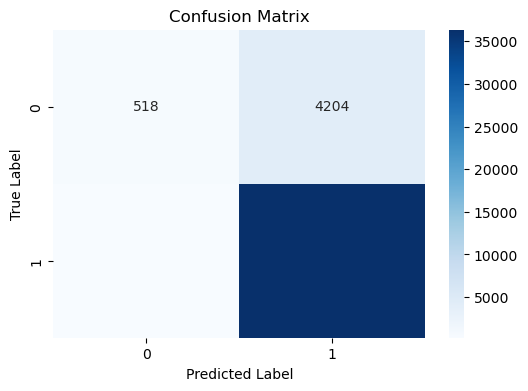

In [14]:
# Generate predictions for the test set
y_pred = lgr_pipe.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
metrics = calculate_metrics(cm)
print("Metrics:")  
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Metrics:
accuracy: 0.8927
sensitivity (recall): 0.9938
specificity: 0.1097
precision: 0.8964
f1_score: 0.9426
negative predictive value: 0.6953


### Repeat considering battery voltage      

In [16]:
#create train test split with even result ratio
X_train_batt, X_test_batt, y_train_batt, y_test_batt = train_test_split(lgr_model_df_batt.drop(['result'], axis = 1), lgr_model_df_batt['result'], random_state = 42,
                                                   stratify = lgr_model_df_batt['result'])

In [17]:
lgr_model_df_batt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126646 entries, 0 to 165217
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          126646 non-null  int64  
 1   make          126646 non-null  object 
 2   model         126646 non-null  object 
 3   scan_method   126646 non-null  object 
 4   batt_voltage  126646 non-null  float64
 5   result        126646 non-null  int64  
 6   system        126646 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 7.7+ MB


In [18]:
#get the models that make up 80 percent of the data in the training  and test sets
#models_xtrain_80 = get_percentage_of_data('model', 0.8, X_train_batt)
#models_xtest_80 = get_percentage_of_data('model', 0.8, X_test_batt)

In [19]:
lgr_pipe = Create_and_fit_lgr_model(X_train_batt, y_train_batt)
score = lgr_pipe.score(X_train_batt, y_train_batt)
print(f'Training score with batt voltage: {score}')

Training score with batt voltage: 0.8926661332434936


Confusion Matrix Considering Battery Voltage:
[[  367  3270]
 [  147 27878]]


C:\Users\mnaze\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


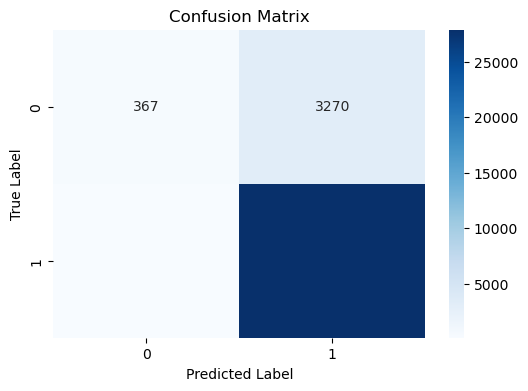

In [20]:
# Generate predictions for the test set
y_pred_batt = lgr_pipe.predict(X_test_batt)

# Create the confusion matrix
cm = confusion_matrix(y_test_batt, y_pred_batt)
print("Confusion Matrix Considering Battery Voltage:")
print(cm)

# Optional: Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
metrics = calculate_metrics(cm)
print("Metrics:")  
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Metrics:
accuracy: 0.8921
sensitivity (recall): 0.9948
specificity: 0.1009
precision: 0.8950
f1_score: 0.9423
negative predictive value: 0.7140


#### Repeat training after reducing system and model counts

In [22]:
#get the models that make up 80 percent of the data in the training  and test sets
models_xtrain_80 = get_percentage_of_data('model', 0.8, X_train)
models_xtest_80 = get_percentage_of_data('model', 0.8, X_test)

In [23]:
type(models_xtrain_80)
print(len(models_xtrain_80))

95


#### 80 percent of the samples are made up by 95 out of 520 models
The top 95 models will be kept and the remaining set to other

In [24]:
#keep 80 percent of models and set the rest to 'other'
X_train['model'] = X_train['model'].apply(
    lambda x: x if x in models_xtrain_80 else 'other'
)

X_test['model'] = X_test['model'].apply(
    lambda x: x if x in models_xtest_80 else 'other'
)

#### The enhanced powertrain system makes up 95 percent of samples

In [25]:
#keep the top 3 systems and set the rest to 'other'
freq = lgr_model_df['system'].value_counts(normalize=True)

# Determine which systems occur in at least 1% of the samples
valid_systems = freq[freq >= 0.01].index.tolist()

# Apply the mapping to the training set: if a system is not in valid_systems, set it to 'other'
X_train['system'] = X_train['system'].apply(
    lambda x: x if x in valid_systems else 'other'
)

# Apply the same mapping to the test set
X_test['system'] = X_test['system'].apply(
    lambda x: x if x in valid_systems else 'other'
)

In [26]:
lgr_pipe_80 = Create_and_fit_lgr_model(X_train, y_train)
score = lgr_pipe_80.score(X_train, y_train) 
print(f'Training score 80 percent of models: {score}')

Training score 80 percent of models: 0.8902859264161145


Confusion Matrix with 80 percent of Makes:
[[  372  4350]
 [  195 36388]]


C:\Users\mnaze\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


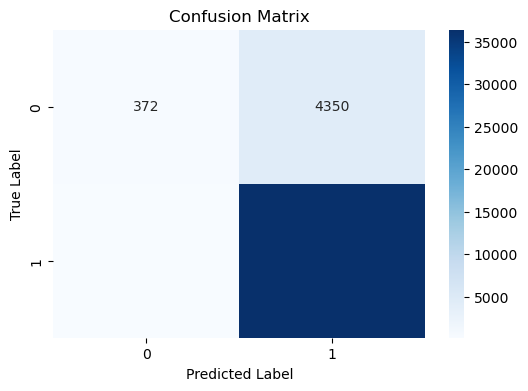

In [27]:
# Generate predictions for the test set
y_pred_base_80 = lgr_pipe_80.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_base_80)
print("Confusion Matrix with 80 percent of Makes:")
print(cm)

# Optional: Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [28]:
metrics = calculate_metrics(cm)
print("Metrics:")   
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Metrics:
accuracy: 0.8900
sensitivity (recall): 0.9947
specificity: 0.0788
precision: 0.8932
f1_score: 0.9412
negative predictive value: 0.6561


#### Repeat with dataset with battery voltage   

In [29]:
#get the models that make up 80 percent of the data in the training  and test sets
models_xtrain_80 = get_percentage_of_data('model', 0.8, X_train_batt)
models_xtest_80 = get_percentage_of_data('model', 0.8, X_test_batt)

In [30]:
type(models_xtrain_80)
print(len(models_xtrain_80))

94


In [31]:
#keep 80 percent of models and set the rest to 'other'
X_train_batt['model'] = X_train_batt['model'].apply(
    lambda x: x if x in models_xtrain_80 else 'other'
)

X_test_batt['model'] = X_test_batt['model'].apply(
    lambda x: x if x in models_xtest_80 else 'other'
)

In [32]:
#keep the top 3 systems and set the rest to 'other'
freq = lgr_model_df['system'].value_counts(normalize=True)

# Determine which systems occur in at least 1% of the samples
valid_systems = freq[freq >= 0.01].index.tolist()

# Apply the mapping to the training set: if a system is not in valid_systems, set it to 'other'
X_train_batt['system'] = X_train_batt['system'].apply(
    lambda x: x if x in valid_systems else 'other'
)

# Apply the same mapping to the test set
X_test_batt['system'] = X_test_batt['system'].apply(
    lambda x: x if x in valid_systems else 'other'
)

In [33]:
lgr_pipe_80_batt = Create_and_fit_lgr_model(X_train_batt, y_train_batt)
score = lgr_pipe_80_batt.score(X_train_batt, y_train_batt) 
print(f'Training score 80 percent of models with battery voltage: {score}')

Training score 80 percent of models with battery voltage: 0.8905184030994694


Confusion Matrix with 80 percent of Makes:
[[  288  3349]
 [  123 27902]]


C:\Users\mnaze\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


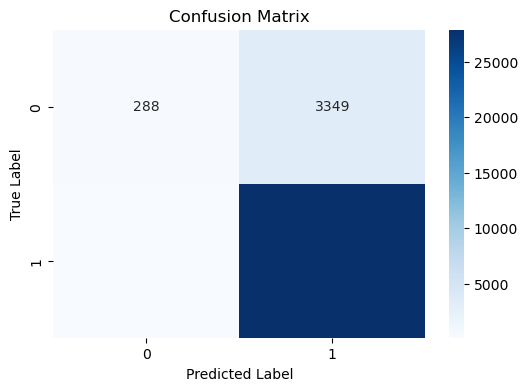

In [34]:
# Generate predictions for the test set
y_pred_base_80_batt = lgr_pipe_80_batt.predict(X_test_batt)

# Create the confusion matrix
cm = confusion_matrix(y_test_batt, y_pred_base_80_batt)
print("Confusion Matrix with 80 percent of Makes:")
print(cm)

# Optional: Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [35]:
metrics = calculate_metrics(cm)
print("Metrics:")   
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Metrics:
accuracy: 0.8903
sensitivity (recall): 0.9956
specificity: 0.0792
precision: 0.8928
f1_score: 0.9414
negative predictive value: 0.7007
